In [1]:
import mbuild as mb
from openff.toolkit.topology import Molecule
import random
import numpy
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
thiophene = mb.load("c1ccsc1",smiles=True)
thiophene.save("thio.sdf",overwrite=True)

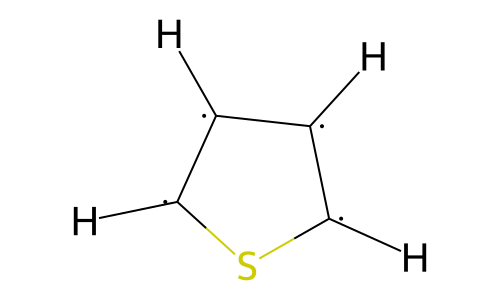

In [3]:
compound = Molecule.from_file("thio.sdf",file_format = "sdf")
compound.visualize()

In [4]:
def bond_info(atom,mol):
    bonds = [b for b in mol.bonds if atom.molecule_atom_index in [b.atom1_index,b.atom2_index]]
    bond_order = numpy.sum(b.bond_order for b in bonds)
    return(bonds, bond_order)
bond_info(compound.atoms[0],compound)

([Bond(atom1 index=1, atom2 index=0),
  Bond(atom1 index=4, atom2 index=0),
  Bond(atom1 index=5, atom2 index=0)],
 3)

In [5]:
next_atom_list = []
def next_atoms(atom,mol):
    for i in range(len(bond_info(atom,mol)[0])):
        n = bond_info(atom,mol)[0][i].atom1
        m = bond_info(atom,mol)[0][i].atom2
        if n not in next_atom_list:
            next_atom_list.append(n)
        if m not in next_atom_list:
            next_atom_list.append(m)
        if atom in next_atom_list:
            next_atom_list.remove(atom)
    return(next_atom_list)
next_atoms(compound.atoms[0],compound)

[Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=1)]

In [6]:
octet = {
        6 : 4,
        7 : 3,
        1 : 1,
        8 : 2,
        16 : 2}

def check_octet(atom,mol):
    bonds = bond_info(atom,compound)[0]
    bond_order = bond_info(atom,compound)[1]
    target = octet[atom.atomic_number]
    if bond_order > target:
        #happy[atom.molecule_atom_index] = False
        add_order = -1
    if bond_order == target:
        #happy[atom.molecule_atom_index] = True
        add_order = 0
    if bond_order < target:
        #happy[atom.molecule_atom_index ] = False
        add_order = 1
    if add_order != 0:
        happy = False
    else:
        happy = True
    return(add_order,happy)
check_octet(compound.atoms[0],compound)

(1, False)

In [ ]:
    """let's just increase the bond order of this 
    bond and try walking to the next atom, 
    aiming to come back if it's too high"""
    """inc_bond cant be in for loop or it adds 
    add_order onto the bondorder 3 times instead of once"""

In [26]:
def walk_molecule(atom, mol, visited, happy):
    visited[atom.molecule_atom_index]=True
    bonds = [b for b in mol.bonds if atom.molecule_atom_index in [b.atom1_index,b.atom2_index]]
    atom_bond_order = bond_info(atom,compound)[1]
    print("im on {}, which is a {}".format(atom.molecule_atom_index,atom.atomic_number) )
    for i in next_atoms(atom,mol):
        next_atom = next_atoms(atom,mol)[0]
    #next_atom = random.choice(next_atoms(atom,mol)) #I want this to choose a new random number each time walk_bond is called
    atom_octet=check_octet(atom,mol)[1]
    next_atom_octet = check_octet(next_atom,mol)[1]
    print(atom_octet,next_atom_octet)
    inc_bond = [ib for ib in bonds if next_atom.molecule_atom_index in [ib.atom1_index,ib.atom2_index]]
    print(inc_bond)
    for bond in inc_bond:
        if atom_octet == False and next_atom_octet == False:
            bond.bond_order += 1
    for b in bonds:
        if visited[next_atom.molecule_atom_index] == False:
            walk_molecule(mol.atoms[next_atom.molecule_atom_index],compound,visited,happy)
            
compound = Molecule.from_file("thio.sdf",file_format = "sdf")
walk_molecule(compound.atoms[0],compound,[False]*len(compound.atoms),[False]*len(compound.atoms))

im on 0, which is a 6
False False
[Bond(atom1 index=1, atom2 index=0)]
im on 1, which is a 6
True True
[Bond(atom1 index=1, atom2 index=0), Bond(atom1 index=2, atom2 index=1), Bond(atom1 index=6, atom2 index=1)]


In [29]:
def walk_molecule(atom,mol,visited,happy):
    visited[atom.molecule_atom_index] = True
    happy[atom.molecule_atom_index] = check_octet(atom,compound)[1]
    bonds = bond_info(atom,mol)[0]
    atom_octet = check_octet(atom,mol)[1]
    next_atom = random.choice(next_atoms(atom,mol))
    next_atom_octet = check_octet(next_atom,mol)[1]
    inc_bond = [ib for ib in bonds if next_atom.molecule_atom_index in [ib.atom1_index,ib.atom2_index]]
    if atom_octet == False and next_atom_octet == False:
        inc_bond[0].bond_order += 1
        
    for i in range(len(happy)):
        if happy[atom.molecule_atom_index] !=  True:
            walk_molecule(mol.atoms[next_atom.molecule_atom_index],compound,visited,happy)

compound = Molecule.from_file("thio.sdf",file_format = "sdf")
walk_molecule(compound.atoms[0],compound,[False]*len(compound.atoms),[False]*len(compound.atoms))

In [66]:
#Goals: Separate our data from our algorithms 
# Make it easier to keep track of is the bond adding going well or not

octet = {
        6 : 4,
        7 : 3,
        1 : 1,
        8 : 2,
        16 : 2}

def check_octet(atom,mol):
    bonds = bond_info(atom,compound)[0]
    bond_order = bond_info(atom,compound)[1]
    target = octet[atom.atomic_number]
    if bond_order > target:
        #happy[atom.molecule_atom_index] = False
        add_order = -1
    if bond_order == target:
        #happy[atom.molecule_atom_index] = True
        add_order = 0
    if bond_order < target:
        #happy[atom.molecule_atom_index ] = False
        add_order = 1
    if add_order != 0:
        happy = False
    else:
        happy = True
    return(add_order,happy)


class MadAtom():
    
    def check_happy(self):
        print("checking", self.index)
        print("\tdesired: ",self.desired_order)
        print("\tcurrent: ",self.current_order)

        if self.desired_order == self.current_order:
            self.happy = True
            return 
        self.happy= False
    
    def __init__(self, i, an, do, co ):
        self.index = i
        self.atomic_number = an
        self.desired_order = do 
        self.current_order = co
        self.visited = False
        self.happy = False
        self.check_happy()

class MadBond():
    def __init__(self,a1,a2,bo):
        self.atom1 = a1
        self.atom2 = a2
        self.order = bo
        self.happy = False
        self.visited = False
        

class BondWalker():
    # data that we need
    # - Molecule we're trying to fix
    # - Our current "state" of whether the sequence of bonds we've tried adding is possible
    # - Octect status of each atom
        #want the index, atomic number, number of bonds that it should have, and number it does have
    
        
    def __init__(self, mol):
        self.atom_list = []
        for atom in mol.atoms:
            self.atom_list.append(MadAtom(atom.molecule_atom_index, atom.atomic_number, octet[atom.atomic_number], len([b for b in mol.bonds if atom.molecule_atom_index in [b.atom1_index,b.atom2_index]]) )) #assumes we have no double bonds at the start
        self.bond_list = [MadBond(b.atom1_index,b.atom2_index,b.bond_order) for b in mol.bonds] # .bond_order inside each of these, and can use atom1_index atom2_index
        
    def bond_increasable(self, b):
        if (not self.atom_list[b.atom1].happy) and (not self.atom_list[b.atom2].happy):
            if (self.atom_list[b.atom1].desired_order > self.atom_list[b.atom1].current_order):
                if (self.atom_list[b.atom2].desired_order > self.atom_list[b.atom2].current_order):
                    return True
        return False

    def bond_happy(self,b):
        if self.atom_list[b.atom1].atomic_number == 1 or self.atom_list[b.atom2].atomic_number == 1:
            return True
        self.atom_list[b.atom1].check_happy()
        self.atom_list[b.atom2].check_happy()
        
        print("and accessing the data...")
        print(self.atom_list[b.atom1].happy, self.atom_list[b.atom2].happy)
        
        
        if self.atom_list[b.atom2].happy and self.atom_list[b.atom1].happy:
            print("this bond is happy")
            return True
        print("this bond is NOT happy")
        return False
    
    def molecule_sad(self):
        for b in self.bond_list:
            if not b.happy:
                return True
        return False

    
    def undo_changes(self,badpath):
        for i,b in enumerate(self.bond_list):
            if i in badpath:
                print("undoing ",i)
                b.order -= 1
                self.atom_list[b.atom1].current_order -=1
                self.atom_list[b.atom2].current_order -=1
                b.happy = self.bond_happy(b)
                print(" and my happy=", b.happy)

    def fill_in_bonds(self):
        # INcrease the bond order of any bonds that are too low, to make sure every atom is happy
        # try again if we run into a corner and can't satisfy the molecule
        # Try out iterating over all bonds instead of atoms
        for b in self.bond_list: #let's check to see which bonds are happy or not
            b.happy = self.bond_happy(b)
            if b.happy:
                b.visited = True
            
        for b in self.bond_list:
            print("Atoms {}-{} {}-{} is {}".format(b.atom1,self.atom_list[b.atom1].atomic_number, b.atom2,self.atom_list[b.atom2].atomic_number,b.happy))#
        #got our happy and sad bonds
        #next, let's try increasing the bond order for these bonds in order
        path = []
        print()
        for i,b in enumerate(self.bond_list):
            if self.bond_increasable(b) and b.visited == False:# check happiness of atoms on either side and see whether or not we CAN increase order
                print("incrementing bond", i)
                #seems like this block working
                path.append(i)
                b.order += 1
                self.atom_list[b.atom1].current_order +=1
                self.atom_list[b.atom2].current_order +=1
                #MISSING: we need to check if these bonds are happy now
                b.happy = self.bond_happy(b)
        
        #down here we need logic for trying other bonds if we run into dead end
        # will need to undo the changes we made before or 
        badpath  = path
        path = []
        if self.molecule_sad():
            self.undo_changes(badpath)
            print("SECOND round")
            for i,b in enumerate(self.bond_list):
                print("Atoms {}-{} {}-{} is {}".format(b.atom1,self.atom_list[b.atom1].atomic_number, b.atom2,self.atom_list[b.atom2].atomic_number,b.happy))
                if self.bond_increasable(b) and b.visited == False and i != badpath[0]:# check happiness of atoms on either side and see whether or not we CAN increase order
                    print("incrementing bond",i)
                    #seems like this block working
                    path.append(i)
                    b.order += 1
                    self.atom_list[b.atom1].current_order +=1
                    self.atom_list[b.atom2].current_order +=1
                    #MISSING: we need to check if these bonds are happy now
                    b.happy = self.bond_happy(b)

        print(path)
        for b in self.bond_list:
            print(b.happy)
                
        
compound = Molecule.from_file("thio.sdf",file_format = "sdf")
bondwalker = BondWalker(compound)
bondwalker.fill_in_bonds()
#print(bondwalker.atom_list[0].current_order)

checking 0
	desired:  4
	current:  3
checking 1
	desired:  4
	current:  3
checking 2
	desired:  4
	current:  3
checking 3
	desired:  2
	current:  2
checking 4
	desired:  4
	current:  3
checking 5
	desired:  1
	current:  1
checking 6
	desired:  1
	current:  1
checking 7
	desired:  1
	current:  1
checking 8
	desired:  1
	current:  1
checking 1
	desired:  4
	current:  3
checking 0
	desired:  4
	current:  3
and accessing the data...
False False
this bond is NOT happy
checking 2
	desired:  4
	current:  3
checking 1
	desired:  4
	current:  3
and accessing the data...
False False
this bond is NOT happy
checking 3
	desired:  2
	current:  2
checking 2
	desired:  4
	current:  3
and accessing the data...
True False
this bond is NOT happy
checking 4
	desired:  4
	current:  3
checking 0
	desired:  4
	current:  3
and accessing the data...
False False
this bond is NOT happy
checking 4
	desired:  4
	current:  3
checking 3
	desired:  2
	current:  2
and accessing the data...
False True
this bond is NOT 

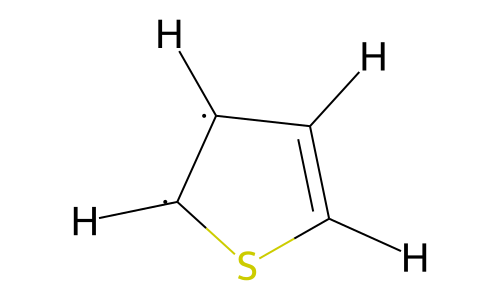

In [30]:
compound.visualize()

In [ ]:
##check to see which bond orders increased and which indices belong to the bond. 
bond_list = [b for b in compound.bonds]
for b in bond_list:
    #print(b.atom1_index,b.atom2_index)
    print(b.bond_order)

In [ ]:
for b in bonds:
        next_atom = b.atom1
        if b.atom1_index == atom.molecule_atom_index:
            next_atom = b.atom2 
        if next_atom not in next_atom_list:
            next_atom_list.append(next_atom)
        next_atom = random.choice(next_atom_list)
        octet_atom = check_octet(atom,compound)[1]
        octet_next = check_octet(next_atom,compound)[1]

In [ ]:
    #for bond in bonds:
    #    if next_atom.molecule_atom_index in [bond.atom1_index,bond.atom2_index]:
    #        if atom_octet and next_atom_octet == False:
    #            bond.bond_order = bond.bond_order + 1
    #    #increase bond between atom and next atom
        
    #inc_bond = [ib for ib in bonds if next_atom.molecule_atom_index in [ib.atom1_index,ib.atom2_index]]
    #if octet_atom == False and octet_next == False:
    #    inc_bond[0].bond_order += 1
    #for b in bonds:
    #    if visited[next_atom.molecule_atom_index] == False:
    #        walk_molecule(mol.atoms[next_atom.molecule_atom_index],compound,visited,happy)
#
    #    print(octet_atom,octet_next)

In [ ]:
#bond_list = [b for b in compound.bonds if 1 not in [b.atom1.atomic_number, b.atom2.atomic_number]]
#atom_list = [a for a in compound.atoms if 1 not in [a.atomic_number]]
#def add_bonds(atom1_index, atom2_index, mol):
#    change_bonds1 = [b for b in mol.bonds if atom1_index in [b.atom1_index,b.atom2_index]]
#    change_bonds2 = [b for b in change_bonds1 if atom2_index in [b.atom1_index,b.atom2_index]]
#    change_bond = change_bonds2[0]
#    original_order = change_bond.bond_order
#    change_bond.bond_order = original_order + 1
#    print(change_bond.bond_order)
#add_bonds(1,2,compound)
#add_bonds(4,5,compound)
#add_bonds(6,7,compound)
#add_bonds(0,8,compound)

In [ ]:
    #new_add_order = check_octet(atom,mol,happy)[0]
    #print(new_add_order)
#    if new_order > target:
#        print("\t too many electrons, decrementing the bond I came from")
#        visited[atom.molecule_atom_index]==False
#        new_add_order = -1 
#    if new_order == target:
#        #happy[atom.molecule_atom_index] = True
#        new_add_order =0
#        print("\t and now I have the right number of bonds")
#    if new_order < target:
#        #happy[atom.molecule_atom_index ] = False
#        print("\t too few electrons, let's try increasing some bond order") 
#inc_bond = [ib for ib in bonds if next_atom.molecule_atom_index in [b.atom1_index,b.atom2_index]]
#    inc_bond[0].bond_order += new_add_order
#    print(new_add_order)  #should be -1 for atom 1, because it has a bond order of 5, but its not??